# First implementation of a GNN (GCN)
In this notebook, we build the graph from an initial dataframe, and we execute the first implementation of our GNN, which contains 1 convolutive layer and 1 fully-connected layer.

## Notebook plan : 
1. Building the graph
2. Building the GCN

In [13]:
import pandas as pd
import numpy as np
from models.BuildGraph import BuildGraph
from models.GCN import GCN
import torch

## 1. Building the graph
Here, we split the patients by tumour type. We merge tumour types if they contain only 1 patient.

### Reading the dataset

In [14]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df["Clinical benefit"] = np.where(df["Clinical benefit"]=="DCB",1,0)
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,0,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,0,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,0,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,0,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,0,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,1,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,0,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,0,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,0,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


In [15]:
buildgraph = BuildGraph(df)

### Compute the adjacency matrix

In [16]:
buildgraph.compute_adjacency_matrix("Tumour type")
display(buildgraph.A)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Build the graph

In [17]:
features_label = ["CD8+ T cell score","Exome mut per mb"]
y_label = "Clinical benefit"

buildgraph.create_graph(features_label, y_label)

### Show the graph

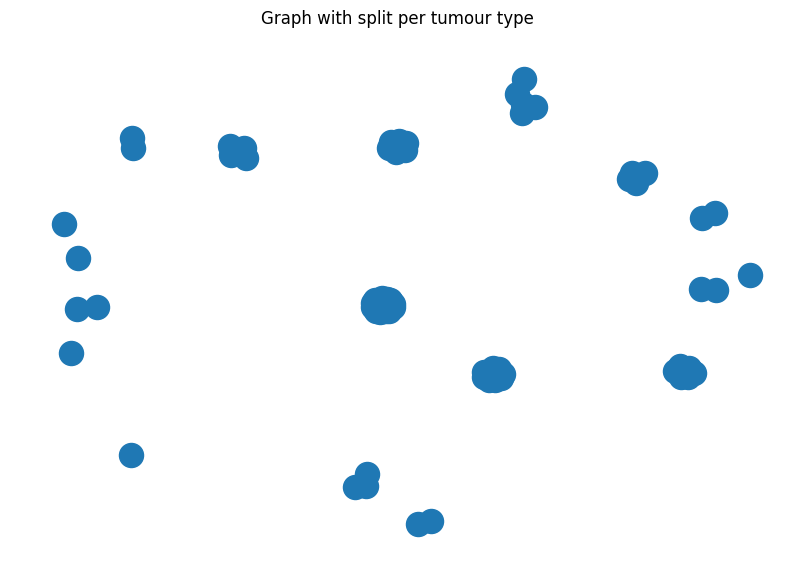

In [18]:
buildgraph.show_graph("Graph with split per tumour type","tumour-type.png")

## 2. Building the GCN

### Formatting data
We convert the Networkx graph to a PyTorch Geometric graph.

In [19]:
from torch_geometric.utils.convert import from_networkx

pyg_graph = from_networkx(buildgraph.G)
pyg_graph.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

### Instanciate the GCN and test a forward pass

In [20]:
model = GCN(2)
print(model)

GCN(
  (conv): GCNConv(2, 2)
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [21]:
out, h = model(pyg_graph.x, pyg_graph.edge_index)
out

tensor([[0.9782],
        [0.7884],
        [0.7722],
        [0.9995],
        [0.9782],
        [0.9782],
        [0.9782],
        [0.9994],
        [0.9170],
        [0.7600],
        [0.9995],
        [0.7600],
        [0.7852],
        [0.9994],
        [0.6937],
        [0.9782],
        [0.9994],
        [0.9782],
        [0.8073],
        [0.8736],
        [0.9782],
        [0.9170],
        [0.9782],
        [0.9782],
        [0.8142],
        [0.9782],
        [0.9170],
        [0.7600],
        [0.9170],
        [0.8055],
        [0.8883],
        [0.8736],
        [0.7600],
        [0.9170],
        [0.7852],
        [0.9995],
        [0.9782],
        [0.9782],
        [0.7884],
        [0.9782],
        [0.9994],
        [0.9170],
        [0.9170],
        [0.9170],
        [0.9782],
        [0.9782],
        [0.9782],
        [0.9170],
        [0.9973],
        [1.0000],
        [0.9973],
        [0.9170],
        [0.9782],
        [0.7300],
        [0.9170],
        [0

### Training

In [22]:
criterion = torch.nn.BCELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

n_epoch = 100
for epoch in range(n_epoch):
    loss, h = train(pyg_graph)
    if epoch % 10 == 0:
        print(f"# epoch {epoch+1}/{n_epoch} :")
        print(f"loss : {loss}")

# epoch 1/100 :
loss : 2.8370361328125
# epoch 2/100 :
loss : 2.697410821914673
# epoch 3/100 :
loss : 2.55854868888855
# epoch 4/100 :
loss : 2.4206557273864746
# epoch 5/100 :
loss : 2.2838945388793945
# epoch 6/100 :
loss : 2.1484625339508057
# epoch 7/100 :
loss : 2.014580249786377
# epoch 8/100 :
loss : 1.8825410604476929
# epoch 9/100 :
loss : 1.7526934146881104
# epoch 10/100 :
loss : 1.6254750490188599
# epoch 11/100 :
loss : 1.5014400482177734
# epoch 12/100 :
loss : 1.3812936544418335
# epoch 13/100 :
loss : 1.2659293413162231
# epoch 14/100 :
loss : 1.1564680337905884
# epoch 15/100 :
loss : 1.0542809963226318
# epoch 16/100 :
loss : 0.9609643220901489
# epoch 17/100 :
loss : 0.8782103061676025
# epoch 18/100 :
loss : 0.8075206279754639
# epoch 19/100 :
loss : 0.7497805953025818
# epoch 20/100 :
loss : 0.7049112915992737
# epoch 21/100 :
loss : 0.6718654632568359
# epoch 22/100 :
loss : 0.6489561796188354
# epoch 23/100 :
loss : 0.6342632174491882
# epoch 24/100 :
loss : 0.6

# epoch 72/100 :
loss : 0.5937296748161316
# epoch 73/100 :
loss : 0.5930196046829224
# epoch 74/100 :
loss : 0.5922663807868958
# epoch 75/100 :
loss : 0.5914759039878845
# epoch 76/100 :
loss : 0.5906557440757751
# epoch 77/100 :
loss : 0.5898141860961914
# epoch 78/100 :
loss : 0.5889599323272705
# epoch 79/100 :
loss : 0.5881009697914124
# epoch 80/100 :
loss : 0.5872445702552795
# epoch 81/100 :
loss : 0.5863970518112183
# epoch 82/100 :
loss : 0.5855633020401001
# epoch 83/100 :
loss : 0.5847466588020325
# epoch 84/100 :
loss : 0.5839493870735168
# epoch 85/100 :
loss : 0.5831723809242249
# epoch 86/100 :
loss : 0.5824153423309326
# epoch 87/100 :
loss : 0.5816771388053894
# epoch 88/100 :
loss : 0.580955982208252
# epoch 89/100 :
loss : 0.580249547958374
# epoch 90/100 :
loss : 0.5795552134513855
# epoch 91/100 :
loss : 0.5788704752922058
# epoch 92/100 :
loss : 0.5781927108764648
# epoch 93/100 :
loss : 0.5775197744369507
# epoch 94/100 :
loss : 0.5768494606018066
# epoch 95/10

#### Test

In [23]:
out2, h2 = model(pyg_graph.x, pyg_graph.edge_index)
out2

tensor([[0.2730],
        [0.3947],
        [0.4019],
        [0.1439],
        [0.2730],
        [0.2730],
        [0.2730],
        [0.1506],
        [0.3393],
        [0.3993],
        [0.1439],
        [0.3993],
        [0.3989],
        [0.1506],
        [0.3757],
        [0.2730],
        [0.1506],
        [0.2730],
        [0.3928],
        [0.3662],
        [0.2730],
        [0.3393],
        [0.2730],
        [0.2730],
        [0.3883],
        [0.2730],
        [0.3393],
        [0.3993],
        [0.3393],
        [0.3921],
        [0.3579],
        [0.3662],
        [0.3993],
        [0.3393],
        [0.3989],
        [0.1439],
        [0.2730],
        [0.2730],
        [0.3947],
        [0.2730],
        [0.1506],
        [0.3393],
        [0.3393],
        [0.3393],
        [0.2730],
        [0.2730],
        [0.2730],
        [0.3393],
        [0.1908],
        [0.0414],
        [0.1908],
        [0.3393],
        [0.2730],
        [0.4132],
        [0.3393],
        [0